In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.formula.api as smf

## Prepare Data

In [ ]:
sfreq = 512
tmin = -0.2
rows = []

yeo7 = {
    'N1': 'Visual',
    'N2': 'Somatomotor',
    'N3': 'DorsalAttention',
    'N4': 'VentralAttention',
    'N5': 'Limbic',
    'N6': 'Frontoparietal',
    'N7': 'Default',
    'mwall': 'Medial_Wall',
}

hemisferes = ['lh', 'rh']

roi_names = [yeo7[k] + '_' + hemisferes[i] 
           for k in yeo7.keys() 
           for i in range(len(hemisferes))]

windows = {
    "early": (0.05, 0.15),
    "mid":   (0.15, 0.35),
    "late":  (0.35, 0.80),
}

for fname in Path("data/labels/").glob("*_labels.npz"):
    subj, movie, order, _ = fname.stem.split("_", 3)
    subj = int(subj)

    npz = np.load(fname)
    X = npz[npz.files[0]]  # (epochs, rois, times)
    if X.ndim != 3:
        raise ValueError(f"{fname.name}: expected (epochs, rois, times), got {X.shape}")

    n_epochs, n_rois, n_times = X.shape
    times = np.arange(n_times) / sfreq + tmin
    assert np.isclose(times[0], tmin)

    for win, (t0, t1) in windows.items():
        tmask = (times >= t0) & (times < t1)
        if not np.any(tmask):
            raise ValueError(f"{fname.name}: window {win} empty")

        feat = X[:, :, tmask].mean(axis=-1)

        rows.append(pd.DataFrame({
            "subject": subj,
            "movie": movie,
            "condition": order,
            "epoch": np.repeat(np.arange(n_epochs), n_rois),
            "roi": np.tile(np.array(roi_names), n_epochs),
            "window": win,
            "t_start": t0,
            "t_end": t1,
            "amplitude": feat.reshape(-1),
        }))

df = pd.concat(rows, ignore_index=True)
df.to_csv('data/erp_ready_df.csv.gz', compression="gzip")

## MixedML

In [ ]:
df = pd.read_csv("data/ERP/erp_ready_df.csv.gz", compression='gzip')

# remove mdeial wall
df = df.query('~roi.str.contains("Medial_Wall")')

for col in ['condition', 'window', 'roi', 'movie']:
    df[col] = df[col].astype('category')

df['amplitude'] = df['amplitude'] * 1e12

In [ ]:
sub_amp = df.groupby('subject').get_group(10)['amplitude'].values
sns.histplot(sub_amp)
print(sub_amp.mean(), sub_amp.std())

# df.groupby("subject")["amplitude"].mean().describe()

In [ ]:
df_agg = (df.groupby(["subject","condition","window","roi"], observed=True)
            .amplitude.mean().reset_index())
df_agg["amp_z"] = (df_agg["amplitude"] - df_agg["amplitude"].mean()) / df_agg["amplitude"].std()

md = smf.mixedlm(
    "amplitude ~ condition + roi + window + condition:roi + condition:window",
    df,
    groups="subject",
)
m = md.fit(reml=False, method="lbfgs", maxiter=200)
m.pvalues [m.pvalues <= 0.05]

/Users/yeganeh/Codes/MovieEEG-SourcePipeline/.pixi/envs/default/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


roi[T.DorsalAttention_rh]                    0.032157
roi[T.Somatomotor_lh]                        0.002278
roi[T.Somatomotor_rh]                        0.019120
condition[T.nl]:roi[T.DorsalAttention_lh]    0.016662
condition[T.nl]:roi[T.Frontoparietal_lh]     0.017193
condition[T.nl]:roi[T.Visual_lh]             0.019313
condition[T.nl]:roi[T.Visual_rh]             0.003598
subject Var                                  0.000249
dtype: float64

In [ ]:
# Aggregate to epoch-level means
df_ep = (
    df
    .groupby(
        ["subject", "condition", "roi", "window", "epoch"],
        observed=True
    )
    .amplitude
    .mean()
    .reset_index()
)


# make epoch numeric and centered
df_ep["epoch_c"] = df_ep["epoch"] - df_ep["epoch"].mean()


md = smf.mixedlm(
    "amplitude ~ condition * roi + condition * epoch + window",
    data=df_ep,
    groups="subject",
    re_formula="~epoch_c"
)

m = md.fit(
    reml=False,
    method="lbfgs",
    maxiter=500
)

## Visualisation

In [2]:
yeo7 = {
    'N1': 'Visual',
    'N2': 'Somatomotor',
    'N3': 'DorsalAttention',
    'N4': 'VentralAttention',
    'N5': 'Limbic',
    'N6': 'Frontoparietal',
    'N7': 'Default',
    'mwall': 'Medial_Wall',
}

hemispheres = ['lh', 'rh']

roi_names = [
    f"{yeo7[k]}_{h}"
    for k in yeo7.keys()
    for h in hemispheres
]


windows = {
    "early": (0.05, 0.15),
    "mid":   (0.15, 0.35),
    "late":  (0.35, 0.80),
}

window_colors = {
    "early": "tab:blue",
    "mid":   "tab:orange",
    "late":  "tab:green",
}

In [ ]:
labels_dir = Path("data/labels")

cond_A_suffixes = ("city_nl", "art_nl")
cond_B_suffixes = ("city_l",  "art_l") 

evoked_A = []
evoked_B = []

# collect subjects from filenames
subjects = sorted({p.name.split("_")[0] for p in labels_dir.glob("*_labels.npz")})

for sub in subjects:
    # scrambled
    file_A = next(
        (labels_dir / f"{sub}_{c}_labels.npz" for c in cond_A_suffixes
         if (labels_dir / f"{sub}_{c}_labels.npz").exists()),
        None
    )

    # linear
    file_B = next(
        (labels_dir / f"{sub}_{c}_labels.npz" for c in cond_B_suffixes
         if (labels_dir / f"{sub}_{c}_labels.npz").exists()),
        None
    )

    if file_A is None or file_B is None:
        print('skip incomplete subjects safely')
        continue

    evoked_A.append(np.load(file_A)["labels"].mean(0))
    evoked_B.append(np.load(file_B)["labels"].mean(0))

evoked_A = np.stack(evoked_A)  # (n_sub, n_rois, n_times)
evoked_B = np.stack(evoked_B)

GA_A = evoked_A.mean(0)
GA_B = evoked_B.mean(0)

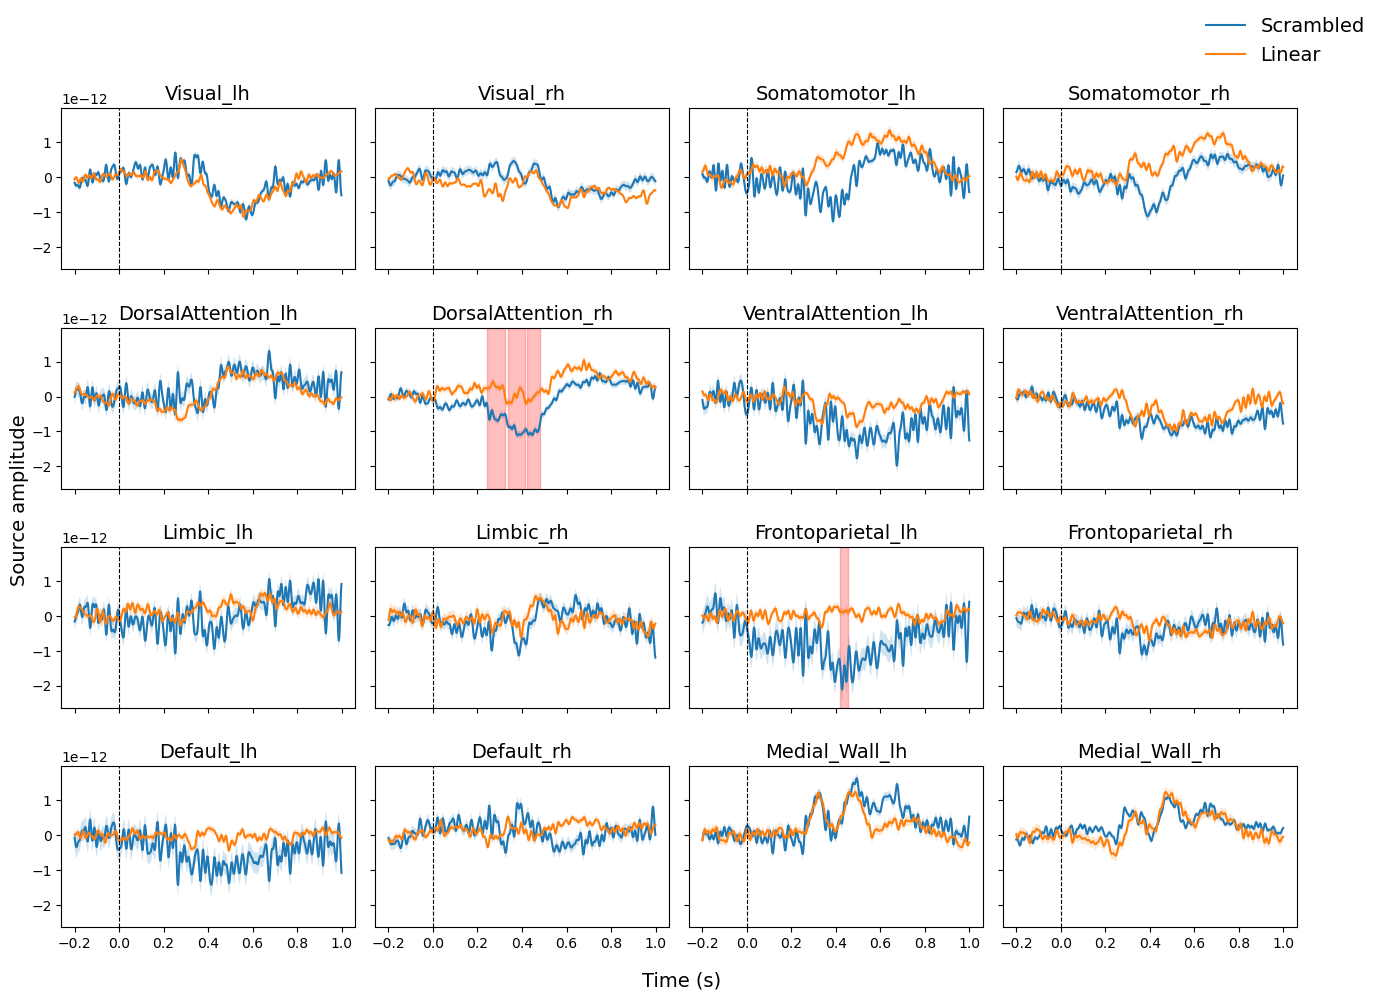

In [ ]:
cluster_shading = {
    "DorsalAttention_rh": [
        (227, 267),
        (275, 314),
        (319, 349),
    ],
    "Frontoparietal_lh": [
        (317, 335),
    ],
}


n_rois = len(roi_names)
n_cols = 4
n_rows = int(np.ceil(n_rois / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(14, 10),
    sharex=True,
    sharey=True
)
freq = 512
tmin = -0.2

axes = axes.flatten()
times = np.arange(615) / freq + tmin

for i, roi in enumerate(roi_names):
    ax = axes[i]

    ax.plot(times, GA_A[i], label="Scrambled", linewidth=1.5)
    ax.plot(times, GA_B[i], label="Linear", linewidth=1.5)

    sem_A = evoked_A[:, i].std(axis=0) / np.sqrt(evoked_A.shape[0])
    sem_B = evoked_B[:, i].std(axis=0) / np.sqrt(evoked_B.shape[0])

    # SEM shading
    ax.fill_between(times, GA_A[i] - sem_A[i], GA_A[i] + sem_A[i], alpha=0.2)
    ax.fill_between(times, GA_B[i] - sem_B[i], GA_B[i] + sem_B[i], alpha=0.2)

    # event onset
    ax.axvline(0, color="k", linestyle="--", linewidth=0.8)

    # cluster-based significant intervals only
    if roi in cluster_shading:
        for t_start, t_end in cluster_shading[roi]:
            ax.axvspan(
                times[t_start],
                times[t_end],
                color="red",
                alpha=0.25
            )

    ax.set_title(roi, fontsize=14)

# remove empty panels
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.supxlabel("Time (s)", fontsize=14)
fig.supylabel("Source amplitude", fontsize=14)
# fig.suptitle("Grand-Average Source ERPs by ROI\n(red shading = cluster-based significant intervals)", fontsize=14)

# single legend (only curves)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", frameon=False, fontsize=14)

plt.tight_layout(rect=[0, 0, 0.95, 0.93])
plt.show()


### Cluster-based permutation test

In [6]:
from mne.stats import permutation_cluster_1samp_test
from statsmodels.stats.multitest import multipletests

alpha = 0.05
n_perm = 2000

cluster_results = {}

for roi_idx, roi in enumerate(roi_names):

    # subject-level difference waves
    X = evoked_A[:, roi_idx, :] - evoked_B[:, roi_idx, :]  # (n_sub, n_times)

    T_obs, clusters, cluster_pvals, _ = permutation_cluster_1samp_test(
        X,
        n_permutations=n_perm,
        threshold=None,
        tail=0,
        out_type="mask",
        n_jobs=1,
        verbose=False
    )

    sig = [
        {
            "roi": roi,
            "p": cluster_pvals[i],
            "t_start": times[clusters[i]][0],
            "t_end": times[clusters[i]][-1],
        }
        for i in range(len(clusters))
        if cluster_pvals[i] <= alpha
    ]

    if sig:
        cluster_results[roi] = sig


In [7]:
cluster_results

{'DorsalAttention_rh': [{'roi': 'DorsalAttention_rh',
   'p': np.float64(0.013),
   't_start': np.float64(0.243359375),
   't_end': np.float64(0.321484375)},
  {'roi': 'DorsalAttention_rh',
   'p': np.float64(0.012),
   't_start': np.float64(0.337109375),
   't_end': np.float64(0.41328125)},
  {'roi': 'DorsalAttention_rh',
   'p': np.float64(0.04),
   't_start': np.float64(0.423046875),
   't_end': np.float64(0.481640625)}],
 'Frontoparietal_lh': [{'roi': 'Frontoparietal_lh',
   'p': np.float64(0.04),
   't_start': np.float64(0.419140625),
   't_end': np.float64(0.454296875)},
  {'roi': 'Frontoparietal_lh',
   'p': np.float64(0.048),
   't_start': np.float64(0.630078125),
   't_end': np.float64(0.665234375)}]}

In [8]:
rows = []
for roi, clusters in cluster_results.items():
    rows.append({
        "roi": roi,
        "min_cluster_p": min(c["p"] for c in clusters)
    })

df_clusters = pd.DataFrame(rows)

rej, p_fdr, _, _ = multipletests(
    df_clusters["min_cluster_p"],
    alpha=0.05,
    method="fdr_bh"
)

df_clusters["p_fdr"] = p_fdr
df_clusters["significant"] = rej

print(df_clusters.sort_values("p_fdr"))


                  roi  min_cluster_p  p_fdr  significant
0  DorsalAttention_rh          0.012  0.024         True
1   Frontoparietal_lh          0.040  0.040         True
